# Import Library

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.spatial import distance
from importlib import reload

# Data Preprocess

### Utility Functions (general)

In [9]:
def match_partnum(df1, df2):
    """
    ensure dataframe df1 and df2 have same part_num
    """
    # find part_num differences between two dataframes
    diff1 = list(set(df1["part_num"]) - set(df2["part_num"]))
    diff2 = list(set(df2["part_num"]) - set(df1["part_num"]))
    
    # drop rows containing part_num that only exist in one of the dataframes
    del_row_idx1 = []
    del_row_idx2 = []
    for i in range(len(diff1)):
        del_row_idx1.append(int(np.where(df1["part_num"] == diff1[i])[0]))
    df1 = df1.drop(del_row_idx1, axis=0)

    for i in range(len(diff2)):
        del_row_idx2.append(int(np.where(df2["part_num"] == diff2[i])[0]))
    df2 = df2.drop(del_row_idx2, axis=0)

    # reset dataframe index to range(part_num), otherwise there is a mismatch of index between 
    # df1 and df2 since index won't be reassigned when droping rows. Such mismatch leads
    # NaN values when calculating particle movement
    df1 = df1.set_index(pd.Index(range(len(df1["part_num"]))))
    df2 = df2.set_index(pd.Index(range(len(df2["part_num"]))))
    
    return df1, df2

def drop_nan(df):
    """drop any rows containing NaNs"""
    # find row index containing NaNs
    row_idx = df.isnull().any(axis=1).to_numpy().nonzero()[0]
    
    # drop corresponding rows
    df = df.drop(row_idx, axis=0)
    
    return df

def cross_section(df, x_range=None, y_range=None, z_range=None):
    """choose part_num within the given x, y, z range"""
    
    if x_range != None:
        df = df.loc[(df['x'] >= x_range[0]) & (df['x'] <= x_range[1])]
    if y_range != None:
        df = df.loc[(df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]
    if z_range != None:
        df = df.loc[(df['z'] >= z_range[0]) & (df['z'] <= z_range[1])]
    
    return df["part_num"]

### Utility Functions (movement)

In [8]:
def read_data_movement(folder, step):
    """
    read single step particle property file
    """
    # define file path and read in the file as dataframe
    file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + str(step)
    data = pd.read_csv(file_path)
    
    return data
    
def _winsorization(df):
    """helper function to perform winsorization"""
    # find the threshold for winsorization
    p = 0.95
    quantile_value = np.quantile(df, p)
    
    # apply winsorizaiton on the given column df
    df = df.apply(lambda x: x if x < quantile_value else quantile_value)
    
    return df

def preprocess_movement(df):
    """
    collections of functions to preprocess dataframe before clustering analysis
    """
    # change movement into absolute values
    df.iloc[:,4:7] = np.abs(df.iloc[:,4:7])

    # take natural logarithm for movement columns, min_value added to fix extreme value cases
    min_value = 1e-5
    df.iloc[:,4:7] = np.log(df.iloc[:,4:7] + min_value)
    
    # winsorization is not suitable for movement only clustering, it actually makes the clustering results worse
    # df.iloc[:,4:7] = df.iloc[:,4:7].apply(_winsorization, axis = 0)
    
    # standardization 
    tmp = pd.DataFrame(preprocessing.scale(df.iloc[:,4:7]))
    tmp = tmp.set_index(pd.Index(range(len(df["part_num"]))))
    tmp.columns = df.columns[4:7]
    df.iloc[:,4:7] = tmp
    
    return df
    

### Utility Functions (force)

In [13]:
def read_data_force(folder):
    """
    read particle property files for all 303 steps
    forces in x,y,z directions are combined into one value for one step
    different steps' values are saved in different columnes
    """
    data = pd.DataFrame()
    
    # loop through all steps
    for i in range(1,304):
        file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + "_Step" + str(i) + ".csv"
        tmp = pd.read_csv(file_path)
        force = np.sqrt(tmp["F_x"]**2 + 
                        tmp["F_y"]**2 + 
                        tmp["F_z"]**2)
        data[str(i)] = force
    
    # add part_num, x, y, z coordinates at the begining to identify particles
    data.insert(0, "part_num", tmp["part_num"])
    data.insert(1, "x", tmp["centroid_x"])
    data.insert(2, "y", tmp["centroid_y"])
    data.insert(3, "z", tmp["centroid_z"])
    
    return data

def _gaussian_kernel(df_row, df_surround):
    """helper function for applying gaussian kernel"""
    # set weights for spatial 3x3 gaussian kernel
    weights = [4, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    
    # apply gaussian kernel for the corresponding particle df_row
    output = df_surround.multiply(weights, axis=0).copy()
    output = output.sum(axis=0)/sum(weights)
    
    return output

def apply_kernel(df, top_idx):
    """
    apply kernel functions to all the particles
    """
    # copy the df so that any modification on the tmp won't affect the original df
    tmp = df.copy()

    # loop through all particles
    for i in range(len(top_idx)):
        tmp.iloc[i,1:] = _gaussian_kernel(df.iloc[i,1:], df.iloc[top_idx[i],1:])
    
    return tmp

def sort_idx(array):
    """find the top nth particles that are closest to the target particle"""
    # find the top nth particle indexes using np.argsort()
    top_idx = np.argsort(array)[:19]
    return top_idx

def spline_validate(data, knots, labels, mask):
    """
    perform 10-fold cross validation on a given number of knots
    """
    # divide into train and validate datasets
    idx_train = [idx for idx, label in enumerate(labels) if label != mask]
    idx_val = [idx for idx, label in enumerate(labels) if label == mask]
    
    # calculate B-spline coefficients based on training data
    x_train = np.linspace(0, total_time, num = len(idx_train))
    y_train = data.iloc[idx_train]
    tck = interpolate.splrep(x_train, y_train, task = -1, k = 3, t = knots)
    
    # predict y values for validation data
    x_val = [i * time_interval * record_per_step for i in idx_val]
    y_pred = interpolate.splev(x_val, tck)
    y_val = data.iloc[idx_val]
    
    # return sum of squared errors
    return np.sum((y_pred - y_val)**2)

def get_spline_coef(data, knots):
    """
    get B-spline coefficients for a given knots
    """
    x = np.linspace(0, total_time, num = len(data))
    tck = interpolate.splrep(x, data, task = -1, k = 3, t = knots)
    
    return tck[1]

# Clustering

## Center Binding
### Movement

In [111]:
# set folder name and file name
folder_init, folder_final = "cb_d9out", "cb_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# calculate particle movement in x, y, z directions
data_movement = []
data_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
data_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           data_movement], axis=1)
data_movement.index.name = ""
data_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
data_movement = preprocess_movement(data_movement)
# drop part_num 3, 4 because of excessive y-axis force
data_movement = data_movement.drop([2,3]).reset_index(drop=True)
data_movement.head()

,part_num,x,y,z,movement_x,movement_y,movement_z
0,1,0.590680,0.464698,0.219044,-0.794319,-0.566342,-1.776663
1,2,0.621595,0.528801,0.239288,-0.357824,-0.864936,-0.630764
2,5,1.065077,0.488288,0.261308,0.086207,0.006941,-0.654721
3,6,1.063221,0.464308,0.219340,-0.295545,-0.525444,-0.819954
4,7,1.481332,0.583164,0.214781,0.167312,-0.303063,-2.364443


### Force (get coefficients)

In [142]:
# read in files
folder = "cb_d16out"
data_force = read_data_force(folder).drop([2,3])

# read and averaging b-spline coefficients for eight train passes
spline_coef = pd.DataFrame()

for i in range(8):
    if spline_coef.empty:
        file = '../output/spline_coef_cb_' + str(i+9) + '.csv'
        spline_coef = pd.read_csv(file)
        spline_coef = drop_nan(spline_coef)
    else:
        
        file = '../output/spline_coef_cb_' + str(i+9) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_coef, tmp = match_partnum(spline_coef, tmp)
        spline_coef = spline_coef.add(tmp)/2

# get particle x,y,z coordinates
data_force = drop_nan(data_force)
data_force, spline_coef = match_partnum(data_force, spline_coef)
coord = data_force.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)
# apply spatial 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_coef, top_idx)
spline_kernel.head()

,part_num,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,1.0,3.299701,3.337575,5.179921,2.212083,5.260065,2.785450,3.797151,4.475549,3.105089,...,4.233866,3.467226,3.506617,4.459713,3.268414,3.802916,0.0,0.0,0.0,0.0
1,2.0,2.922578,2.892079,4.228307,2.374619,4.111505,2.739753,3.256605,3.633913,2.944105,...,3.248430,2.831840,2.786175,4.200040,2.509484,3.474262,0.0,0.0,0.0,0.0
2,5.0,3.318893,9.900917,8.413347,3.600088,9.275679,3.576467,7.561299,6.085863,6.349360,...,12.248132,2.293151,11.100057,5.926443,5.504911,5.563117,0.0,0.0,0.0,0.0
3,6.0,3.301924,8.943700,7.693325,2.818763,7.348031,3.669454,7.604536,5.926053,6.125032,...,10.022411,1.038866,10.624730,2.668798,6.174754,4.124780,0.0,0.0,0.0,0.0
4,7.0,7.522549,17.111072,51.799877,-9.558476,37.535798,4.314476,7.477634,6.831913,5.999019,...,41.761705,3.586591,29.421441,28.889488,-5.857956,10.223408,0.0,0.0,0.0,0.0


### Force (apply PCA)

In [143]:
# preprocess spline coefficients with kernel function applied
spline_kernel_raw = np.log(np.abs(spline_kernel.iloc[:,5:25])+0.0001)
# apply standardizaiton and PCA
spline_kernel_std = StandardScaler().fit_transform(spline_kernel_raw)
spline_kernel_pca = PCA(n_components=3).fit_transform(spline_kernel_std)
spline_kernel_pca = pd.DataFrame(spline_kernel_pca)
spline_kernel_pca.columns = ['1st dir', '2nd dir', '3rd dir']
spline_kernel_pca.head()

,1st dir,2nd dir,3rd dir
0,-3.323422,1.091531,0.321381
1,-3.882633,0.844425,0.282777
2,-1.027414,2.263979,-0.569943
3,-1.584310,2.247445,-0.747500
4,0.661811,1.930022,-0.330671


### Combine

In [144]:
# combine both movement and force features
feature = pd.concat([data_movement.iloc[:,4:7], spline_kernel_pca], axis=1)
# standardize features for clustering
feature_std = pd.DataFrame(columns = col_name)
feature_std = StandardScaler().fit_transform(feature)
feature_std = pd.DataFrame(feature_std)
feature_std.columns = ['movement_x', 'movement_y', 'movement_z', '1st dir', '2nd dir', '3rd dir']
feature_std.head()

,movement_x,movement_y,movement_z,1st dir,2nd dir,3rd dir
0,-0.794883,-0.566400,-1.777388,-0.988295,0.588824,0.285303
1,-0.358243,-0.864980,-0.631221,-1.154589,0.455523,0.251033
2,0.085935,0.006856,-0.655184,-0.305525,1.221298,-0.505962
3,-0.295943,-0.525504,-0.820455,-0.471131,1.212379,-0.663586
4,0.167067,-0.303134,-2.365305,0.196805,1.041146,-0.293550


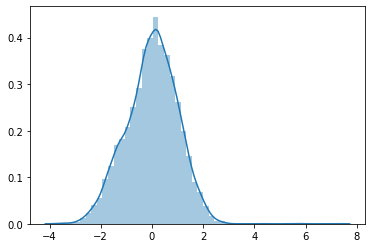

In [145]:
%matplotlib inline

# get a intuition of data distributions
sns.distplot(pd.DataFrame(feature_std["2nd dir"]))


In [146]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(feature_std)

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_kernel["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_combine_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_combine_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({4: 3112, 0: 3082, 1: 1853, 3: 1700, 2: 1677})


## Full Support
### Movement

In [164]:
# set folder name and file name
folder_init, folder_final = "fs_d7out", "fs_d14out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# calculate particle movement in x, y, z directions
data_movement = []
data_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
data_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           data_movement], axis=1)
data_movement.index.name = ""
data_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
data_movement = preprocess_movement(data_movement)
# drop part_num 3, 4 because of excessive y-axis force
data_movement = data_movement.drop([2,3]).reset_index(drop=True)
data_movement.head()

,part_num,x,y,z,movement_x,movement_y,movement_z
0,1,0.588429,0.464272,0.217803,-1.324526,-1.573638,-2.589553
1,2,0.618625,0.528252,0.237772,-0.540996,-0.764423,-0.923271
2,5,1.063574,0.488989,0.261487,0.214216,-0.367803,0.144108
3,6,1.060801,0.464395,0.219256,-0.011536,-0.496512,-0.986408
4,7,1.487653,0.585113,0.214780,-0.733234,-1.250567,-2.554587


### Force

In [163]:
# read in files
folder = "fs_d14out"
data_force = read_data_force(folder).drop([2,3])

# read and averaging b-spline coefficients for eight train passes
spline_coef = pd.DataFrame()

for i in range(8):
    if spline_coef.empty:
        file = '../output/spline_coef_fs_' + str(i+7) + '.csv'
        spline_coef = pd.read_csv(file)
        spline_coef = drop_nan(spline_coef)
    else:
        
        file = '../output/spline_coef_fs_' + str(i+7) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_coef, tmp = match_partnum(spline_coef, tmp)
        spline_coef = spline_coef.add(tmp)/2

# get particle x,y,z coordinates
data_force = drop_nan(data_force)
data_force, spline_coef = match_partnum(data_force, spline_coef)
coord = data_force.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)
# apply spatial 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_coef, top_idx)

# preprocess spline coefficients with kernel function applied
spline_kernel_raw = np.log(np.abs(spline_kernel.iloc[:,5:25])+0.0001)
# apply standardizaiton and PCA
spline_kernel_std = StandardScaler().fit_transform(spline_kernel_raw)
spline_kernel_pca = PCA(n_components=3).fit_transform(spline_kernel_std)
spline_kernel_pca = pd.DataFrame(spline_kernel_pca)
spline_kernel_pca.columns = ['1st dir', '2nd dir', '3rd dir']
spline_kernel_pca.head()

,1st dir,2nd dir,3rd dir
0,-1.973367,1.670281,0.068854
1,-3.398161,0.915904,-0.224626
2,1.124565,3.120371,0.478073
3,0.658993,2.305020,0.380434
4,3.087560,3.004178,0.696759


### Combine

In [167]:
# combine both movement and force features
feature = pd.concat([data_movement.iloc[:,4:7], spline_kernel_pca], axis=1)
# standardize features for clustering
feature_std = pd.DataFrame(columns = col_name)
feature_std = StandardScaler().fit_transform(feature)
feature_std = pd.DataFrame(feature_std)
feature_std.columns = ['movement_x', 'movement_y', 'movement_z', '1st dir', '2nd dir', '3rd dir']
feature_std.head()


,movement_x,movement_y,movement_z,1st dir,2nd dir,3rd dir
0,-1.325285,-1.573736,-2.590722,-0.598369,0.902196,0.056703
1,-0.541497,-0.764534,-0.923922,-1.030398,0.494722,-0.184984
2,0.213963,-0.367920,0.143788,0.340993,1.685457,0.393703
3,-0.011864,-0.496627,-0.987079,0.199821,1.245048,0.313295
4,-0.733799,-1.250670,-2.555745,0.936217,1.622696,0.573795


In [168]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(feature_std)

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_kernel["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_combine_fs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_combine_fs.csv', 'FullSup.v3d','library.vlb')

Counter({4: 2928, 3: 2601, 2: 1900, 0: 1702, 1: 1486})


## Lack of Center Support
### Movement

In [170]:
# set folder name and file name
folder_init, folder_final = "locs_d9out", "locs_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# calculate particle movement in x, y, z directions
data_movement = []
data_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
data_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           data_movement], axis=1)
data_movement.index.name = ""
data_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
data_movement = preprocess_movement(data_movement)
# drop part_num 3, 4 because of excessive y-axis force
data_movement = data_movement.drop([2,3]).reset_index(drop=True)
data_movement.shape

(11403, 7)

### Force

In [171]:
# read in files
folder = "locs_d16out"
data_force = read_data_force(folder).drop([2,3])

# read and averaging b-spline coefficients for eight train passes
spline_coef = pd.DataFrame()

for i in range(8):
    if spline_coef.empty:
        file = '../output/spline_coef_locs_' + str(i+9) + '.csv'
        spline_coef = pd.read_csv(file)
        spline_coef = drop_nan(spline_coef)
    else:
        
        file = '../output/spline_coef_locs_' + str(i+9) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_coef, tmp = match_partnum(spline_coef, tmp)
        spline_coef = spline_coef.add(tmp)/2

# get particle x,y,z coordinates
data_force = drop_nan(data_force)
data_force, spline_coef = match_partnum(data_force, spline_coef)
coord = data_force.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)
# apply spatial 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_coef, top_idx)

# preprocess spline coefficients with kernel function applied
spline_kernel_raw = np.log(np.abs(spline_kernel.iloc[:,5:25])+0.0001)
# apply standardizaiton and PCA
spline_kernel_std = StandardScaler().fit_transform(spline_kernel_raw)
spline_kernel_pca = PCA(n_components=3).fit_transform(spline_kernel_std)
spline_kernel_pca = pd.DataFrame(spline_kernel_pca)
spline_kernel_pca.columns = ['1st dir', '2nd dir', '3rd dir']
spline_kernel_pca.shape

(11403, 3)

### Combine

In [173]:
# combine both movement and force features
feature = pd.concat([data_movement.iloc[:,4:7], spline_kernel_pca], axis=1)
# standardize features for clustering
feature_std = pd.DataFrame(columns = col_name)
feature_std = StandardScaler().fit_transform(feature)
feature_std = pd.DataFrame(feature_std)
feature_std.columns = ['movement_x', 'movement_y', 'movement_z', '1st dir', '2nd dir', '3rd dir']
feature_std.shape


(11403, 6)

In [174]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(feature_std)

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_kernel["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_combine_locs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_combine_locs.csv', 'LackofCenterSup.v3d','library.vlb')

Counter({0: 3251, 1: 2342, 3: 2202, 4: 1985, 2: 1623})


## Lack of Rail Seat Support
### Movement

In [176]:
# set folder name and file name
folder_init, folder_final = "lorss_d13out", "lorss_d20out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# calculate particle movement in x, y, z directions
data_movement = []
data_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
data_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           data_movement], axis=1)
data_movement.index.name = ""
data_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
data_movement = preprocess_movement(data_movement)
# drop part_num 3, 4 because of excessive y-axis force
data_movement = data_movement.drop([2,3]).reset_index(drop=True)
data_movement.shape

(11775, 7)

### Force

In [177]:
# read in files
folder = "lorss_d20out"
data_force = read_data_force(folder).drop([2,3])

# read and averaging b-spline coefficients for eight train passes
spline_coef = pd.DataFrame()

for i in range(8):
    if spline_coef.empty:
        file = '../output/spline_coef_lorss_' + str(i+13) + '.csv'
        spline_coef = pd.read_csv(file)
        spline_coef = drop_nan(spline_coef)
    else:
        
        file = '../output/spline_coef_lorss_' + str(i+13) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_coef, tmp = match_partnum(spline_coef, tmp)
        spline_coef = spline_coef.add(tmp)/2

# get particle x,y,z coordinates
data_force = drop_nan(data_force)
data_force, spline_coef = match_partnum(data_force, spline_coef)
coord = data_force.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)
# apply spatial 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_coef, top_idx)

# preprocess spline coefficients with kernel function applied
spline_kernel_raw = np.log(np.abs(spline_kernel.iloc[:,5:25])+0.0001)
# apply standardizaiton and PCA
spline_kernel_std = StandardScaler().fit_transform(spline_kernel_raw)
spline_kernel_pca = PCA(n_components=3).fit_transform(spline_kernel_std)
spline_kernel_pca = pd.DataFrame(spline_kernel_pca)
spline_kernel_pca.columns = ['1st dir', '2nd dir', '3rd dir']
spline_kernel_pca.shape

(11775, 3)

### Combine

In [179]:
# combine both movement and force features
feature = pd.concat([data_movement.iloc[:,4:7], spline_kernel_pca], axis=1)
# standardize features for clustering
feature_std = pd.DataFrame(columns = col_name)
feature_std = StandardScaler().fit_transform(feature)
feature_std = pd.DataFrame(feature_std)
feature_std.columns = ['movement_x', 'movement_y', 'movement_z', '1st dir', '2nd dir', '3rd dir']
feature_std.shape


(11775, 6)

In [180]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(feature_std)

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_kernel["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_combine_lorss.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_combine_lorss.csv', 'LackofRailSeatSup.v3d','library.vlb')

Counter({3: 3436, 4: 2676, 1: 2406, 0: 1837, 2: 1420})
